# Example of using forecast class
The notebook shows teh use of forecast.R class forecast and validates on simulated data.

In [1]:
library(devtools)
library(ggridges)
set.seed(1)

Loading required package: usethis



In [2]:
load_all("../../../hmmTMB")

ℹ Loading hmmTMB
Loading required package: R6

Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.

Loading required package: TMB

Loading required package: ggplot2



## Generate mock data
Use the true model defined in forecast_true_mod.hmm

Simulating states... 100%
Simulating count... 100%
Simulating size... 100%


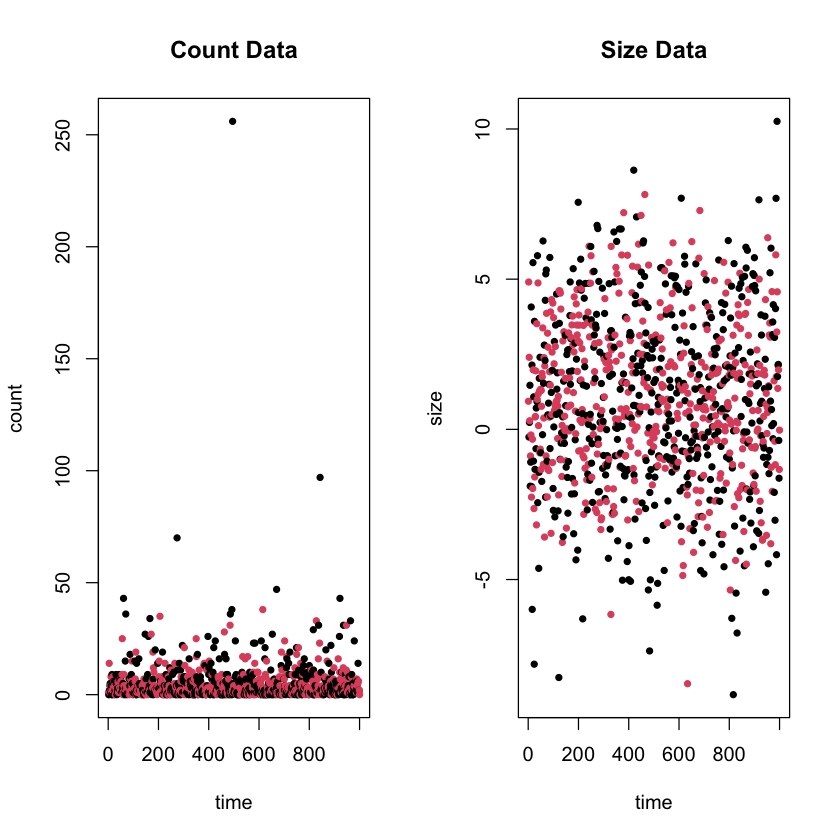

In [3]:
# Simulate data -----------------------------------------------------------

# number of time steps
n <- 1000

# Generate training data with random covariates
empty <- data.frame(
  ID = 1, 
  count = rep(NA, n),
  size = rep(NA, n),
  covariate_1 = rnorm(n, mean = 0, sd = 1),
  covariate_2 = runif(n, min = -1, max = 1),
  covariate_3 = sample(c(-1, 0, 1), n, replace = TRUE)
  #random_effect_id = as.factor(rep(1:2, each = n/2))
)

# create true model
true_mod <- HMM$new(file = "forecast_true_mod.hmm")

# Create a list of random integers for the hidden Markov model coefficients
random_coeff_fe_obs <- replicate(
  length(true_mod$coeff_list()$coeff_fe_obs),
  sample(c(0.9, 1, 1.1, 1.2), 1, replace = TRUE)
)
random_coeff_re_obs <- replicate(
  length(true_mod$coeff_list()$coeff_re_obs),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)
random_log_lambda_obs <- replicate(
  length(true_mod$coeff_list()$log_lambda_obs),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)

# Update the coefficients of the hidden Markov model with the random values
true_mod$obs()$update_coeff_fe(coeff_fe = random_coeff_fe_obs)
true_mod$obs()$update_coeff_re(coeff_re = random_coeff_re_obs)
true_mod$obs()$update_lambda(random_log_lambda_obs)

random_coeff_fe_hid <- replicate(
  length(true_mod$coeff_list()$coeff_fe_hid),
  sample(c(0.9, 1, 1.1, 1.2), 1, replace = TRUE)
)
random_coeff_re_hid <- replicate(
  length(true_mod$coeff_list()$coeff_re_hid),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)
random_log_lambda_hid <- replicate(
  length(true_mod$coeff_list()$log_lambda_hid),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)

true_mod$hid()$update_coeff_fe(coeff_fe = random_coeff_fe_hid)
true_mod$hid()$update_coeff_re(coeff_re = random_coeff_re_hid)
true_mod$hid()$update_lambda(random_log_lambda_hid)

# simulate from true model
training <- true_mod$simulate(n, data = empty)

# update data in true_mod with dat
true_mod$obs()$update_data(training)

# plot data
par(mfrow = c(1, 2)) # set outer margins to 0
plot(training$count, pch = 20, xlab = "time", ylab = "count", col = attr(training, "state"), main = "Count Data")
plot(training$size, pch = 20, xlab = "time", ylab = "size", col = attr(training, "state"), main = "Size Data")
par(mfrow = c(1, 1))


## Fit an hmm model
Fit a model using the model definition of forecast_mod.hmm

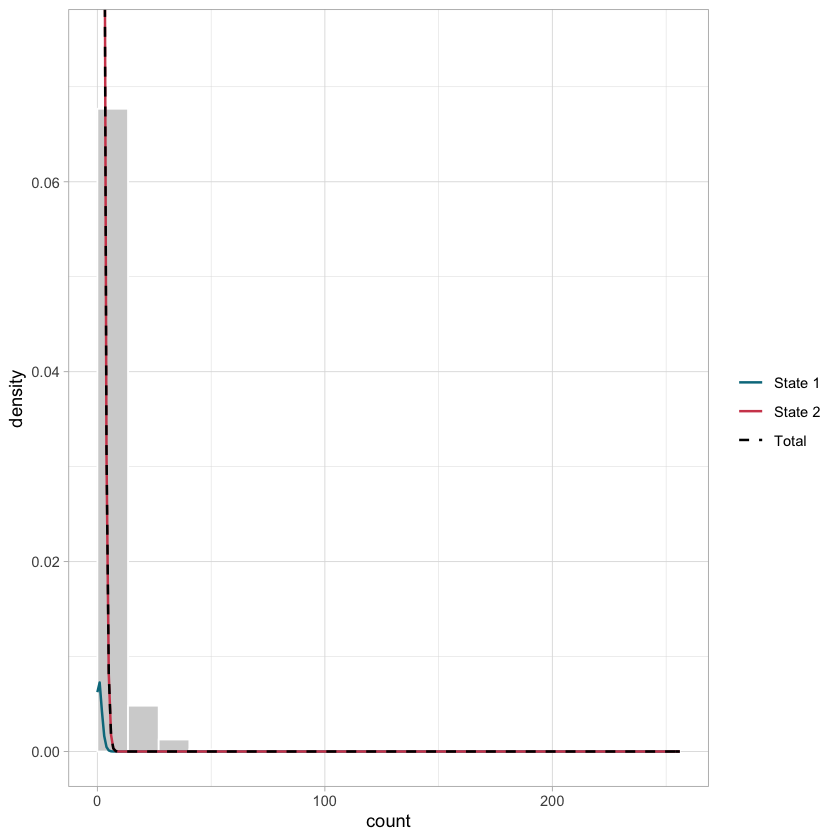

Computing CDFs... done
Computing residuals for count ... done
Computing residuals for size ... done


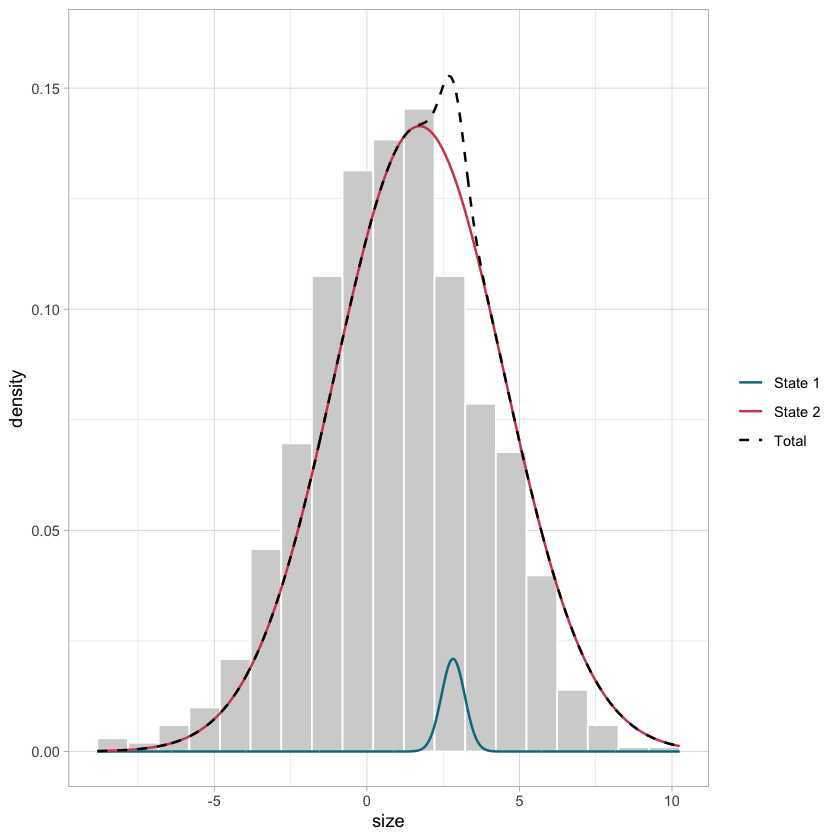

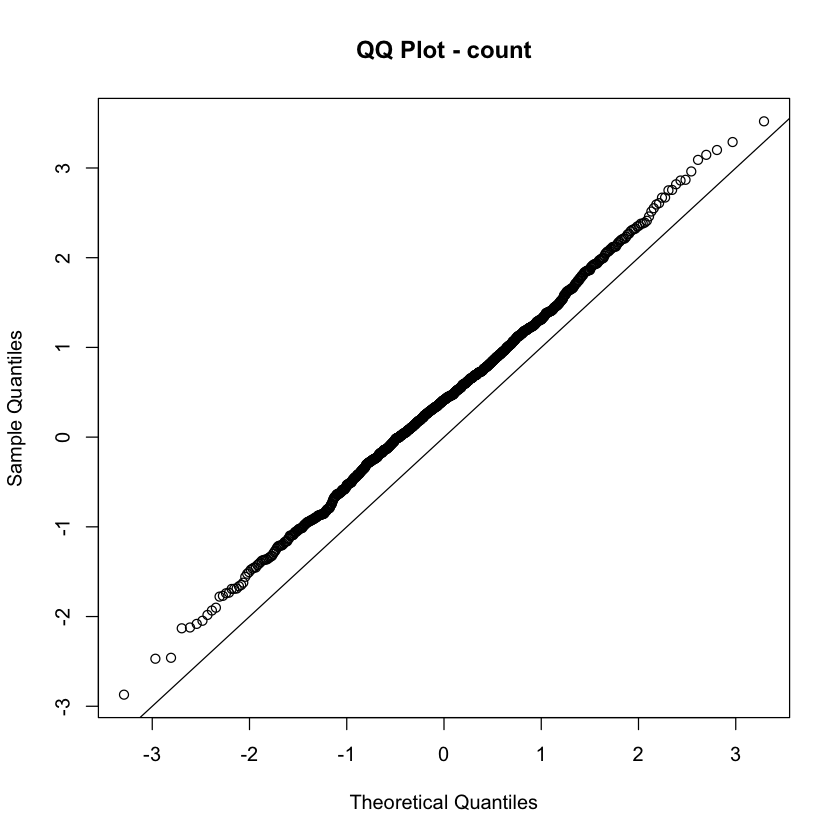

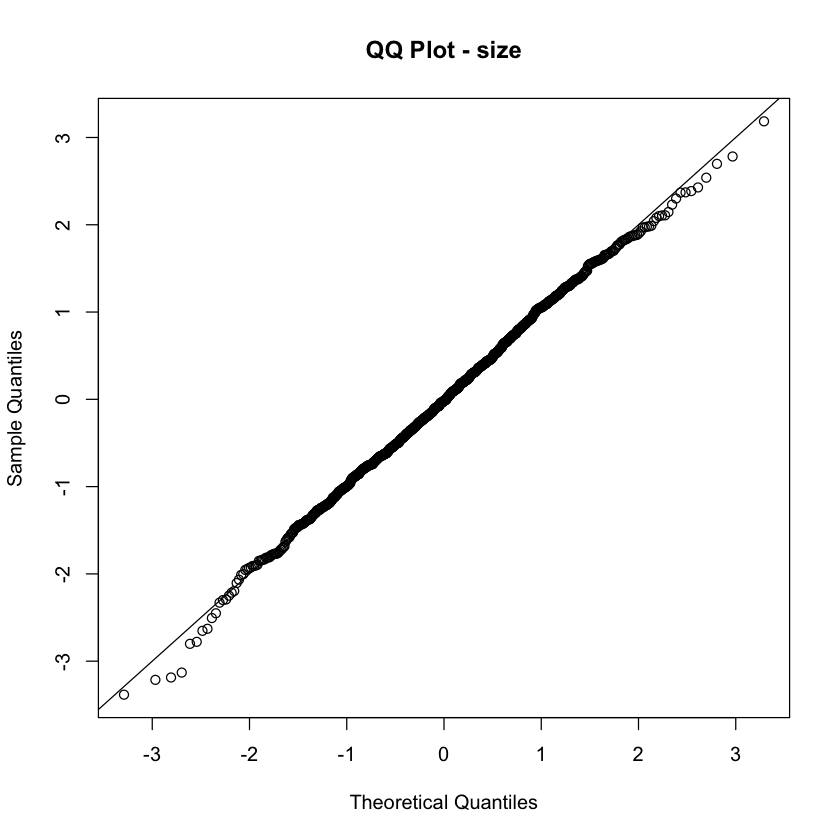

In [4]:
# Fit model ------------------------------------------------------------

# create model to fit 
mod <- HMM$new(file = "forecast_mod.hmm")

# suggest better starting parameters
ini <- mod$suggest_initial()

# set to new starting parameters (or you could edit the specification file)
mod$obs()$update_par(ini)

# fit model
mod$fit(silent = TRUE)

par(mfrow = c(1, 2))
mod$plot_dist("count")
mod$plot_dist("size")
par(mfrow = c(1, 1))

pr <- mod$pseudores()

for (dimension in colnames(mod$obs()$obs_var())) {
  qqnorm(pr[[dimension]], main = paste("QQ Plot -", dimension))
  abline(0, 1)
}

# Forecasting
Use the forecasting class from forecast.R to predict future values

In [5]:
# Set number of observations to predict
n <- 10

# Create new data for prediction, optionally with covariates
forecast_data <- data.frame(
  ID = 1, 
  count = rep(NA, n),
  size = rep(NA, n),
  covariate_1 = rnorm(n, mean = 0, sd = 1),
  covariate_2 = runif(n, min = -1, max = 1),
  covariate_3 = sample(c(-1, 0, 1), n, replace = TRUE),
  random_effect_id = as.factor(rep(1:2, each = n/2))
)

forecast_data

ID,count,size,covariate_1,covariate_2,covariate_3,random_effect_id
<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<fct>
1,NA,NA,-0.27225030,0.2506252,1,1
1,NA,NA,-0.71720824,0.8678033,0,1
1,NA,NA,-0.19532618,-0.2374188,1,1
1,NA,NA,1.31326420,0.5469202,0,1
1,NA,NA,0.01268243,0.3950817,-1,1
1,NA,NA,-1.12421159,0.8369966,-1,2
1,NA,NA,0.85662803,-0.7556111,1,2
1,NA,NA,0.31418212,0.7315667,-1,2
1,NA,NA,0.33667190,0.7975774,1,2


In [6]:
preset_x_vals <- list(
  'count' = seq(0, 100, by = 1)
) 

fc = Forecast$new(
  hmm = mod,
  forecast_data = forecast_data,
  preset_x_vals = preset_x_vals,
)

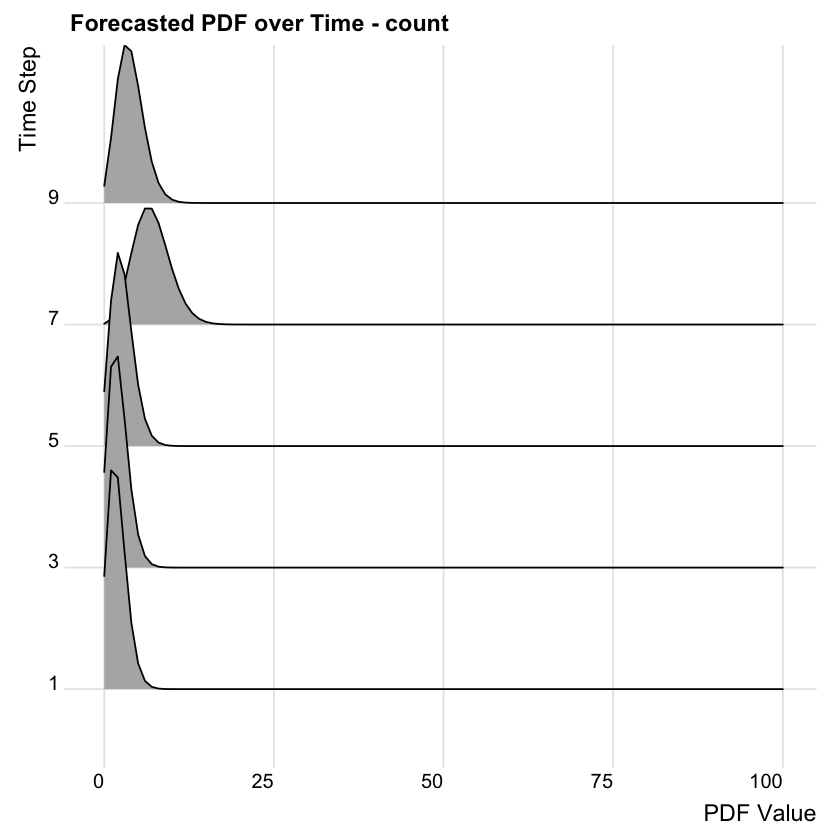

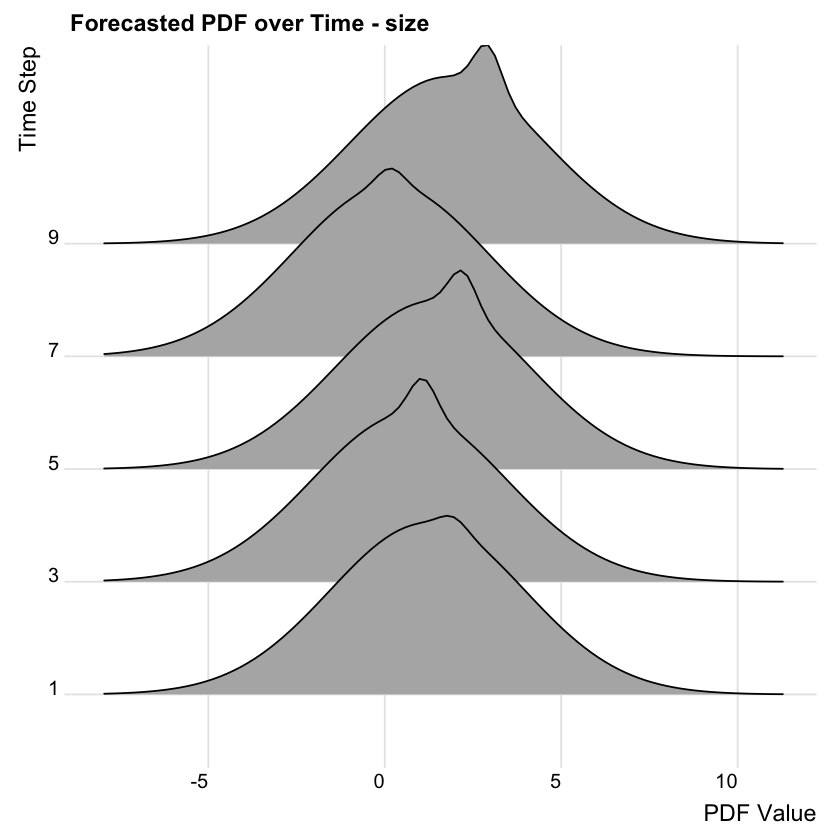

In [7]:
n_steps <- nrow(fc$forecast_data)
plot_steps <- seq(1, n_steps, by = 2)

for (dimension in fc$observation_vars) {
  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(
      fc$x_vals[[dimension]],
      times = length(plot_steps)
    ),
    y = as.vector(fc$forecasted_pdfs[[dimension]][ , plot_steps]),
    time = factor(rep(plot_steps, each = length(fc$x_vals[[dimension]])))
  )
    
  print(ggplot(ridge_data, aes(x = x, y = time, height = y, group = time)) +
    geom_density_ridges(stat = "identity", position = "identity") +
    labs(x = "PDF Value", y = "Time Step", title = paste("Forecasted PDF over Time -", dimension)) +
    theme_ridges() + 
    theme(axis.text.x = element_text(angle = 0, hjust = 1)))
}

## Validate
Create 1000 simulations of the true model using the ending state and the same covariates used in forecasting.

In [8]:
emission_vars <- fc$observation_vars
forecasts <- fc$forecast_data
n_dimensions <- length(emission_vars)
n_simulations <- 1000
n_steps <- nrow(forecasts)

# Get last hidden state
true_last_state <- tail(attr(true_mod$obs()$data(), "state"), 1) # last state
# get TPM of last observation
last_tpm <- true_mod$hid()$tpm(nrow(true_mod$obs()$data()))[, , 1]

# Update delta0 to use distribution of first forecasted state
# TODO: Allow for first distribution to be stationary or custom
true_mod$hid()$update_delta0(last_tpm[true_last_state, ])

# Initialize a named list of 2D arrays to store the simulation results
simulated_data <- list()
for (dimension in emission_vars) {
  simulated_data[[dimension]] <- array(NA, dim = c(n_simulations, n_steps))
}

# Simulate data and store it in the array
for (i in 1:n_simulations) {
  sim <- true_mod$simulate(n = n_steps, data = forecasts, silent = TRUE)

  for (dimension in emission_vars) {
    # Get the simulated data for the current dimension
    simulated_data[[dimension]][i, ] <- sim[[dimension]]
  }
}

# Optionally, print a subset of the simulated data
print(simulated_data[[1]][1:5, ]) # Print the first 5 simulations

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
[1,]    2    4    2   15    3    1    8    1    1     2
[2,]    2    1    0    9    3    1    4    4    4     5
[3,]    4    2    0   10    3    0    5    5    4     3
[4,]    1    1    2   11    2    1    6    2    4     7
[5,]    0    1    1    9    2    0    8    1    5     3


In [9]:
# Convert simulated data to a histogram at each time step
n_dimensions <- length(emission_vars)
n_steps <- nrow(forecasts)

# Initialize a array to store histograms for each time step
simulated_pdfs <- list()


# loop through each dimension and time step 
for (dimension in emission_vars) {

  # Get locations to create histogram bins
  x_vals <- fc$x_vals[[dimension]]

  # Initialize a array to store histograms for each time step
  simulated_pdfs[[dimension]] <- array(NA, dim = c(length(x_vals), n_steps))

  # Define bin width
  bin_width <- x_vals[2] - x_vals[1]

  # Define bin edges such that the x_vals are centered in the bins
  bin_edges <- c(x_vals - bin_width / 2, max(x_vals) + bin_width / 2)

  for (t in 1:n_steps) {
    # Filter simulated data to be within the range of bin edges
    filtered_data <- simulated_data[[dimension]][, t]
    filtered_data <- filtered_data[
      filtered_data >= min(bin_edges) & filtered_data <= max(bin_edges)
    ]

    # Create histogram with specified bin edges
    hist_obj <- hist(filtered_data, plot = FALSE, breaks = bin_edges)

    hist_obj$density <- hist_obj$counts / n_simulations

    simulated_pdfs[[dimension]][, t] <- hist_obj$density
  }

}

simulated_pdfs[[1]][1:5, 1:5]

0.149,0.278,0.137,0.000,0.067
0.296,0.374,0.254,0.000,0.167
0.277,0.212,0.296,0.000,0.234
0.167,0.096,0.161,0.008,0.241
0.074,0.028,0.086,0.014,0.157


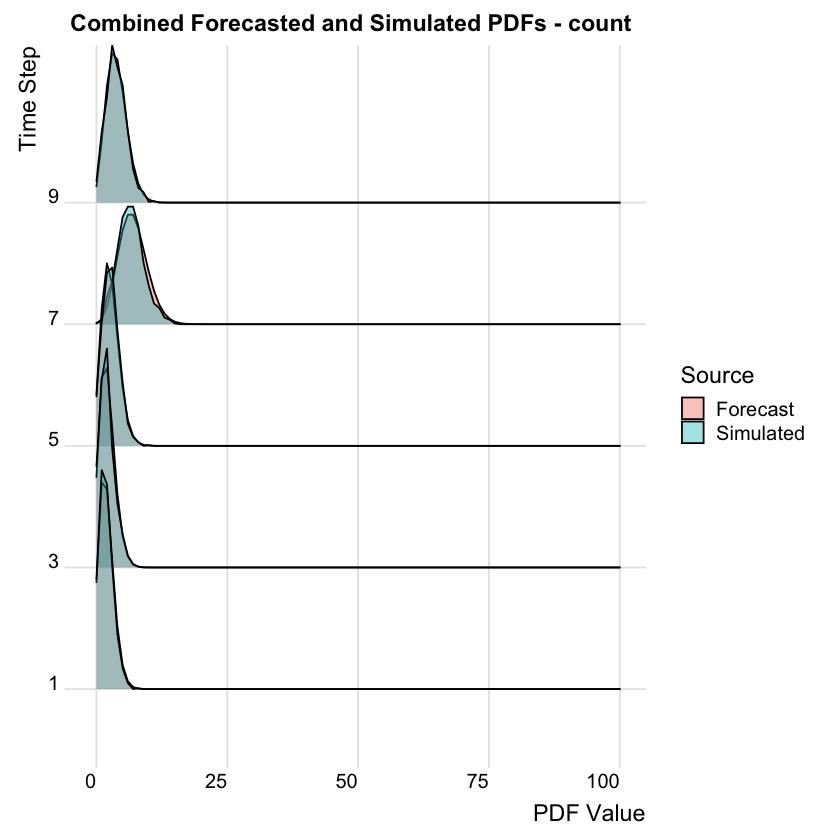

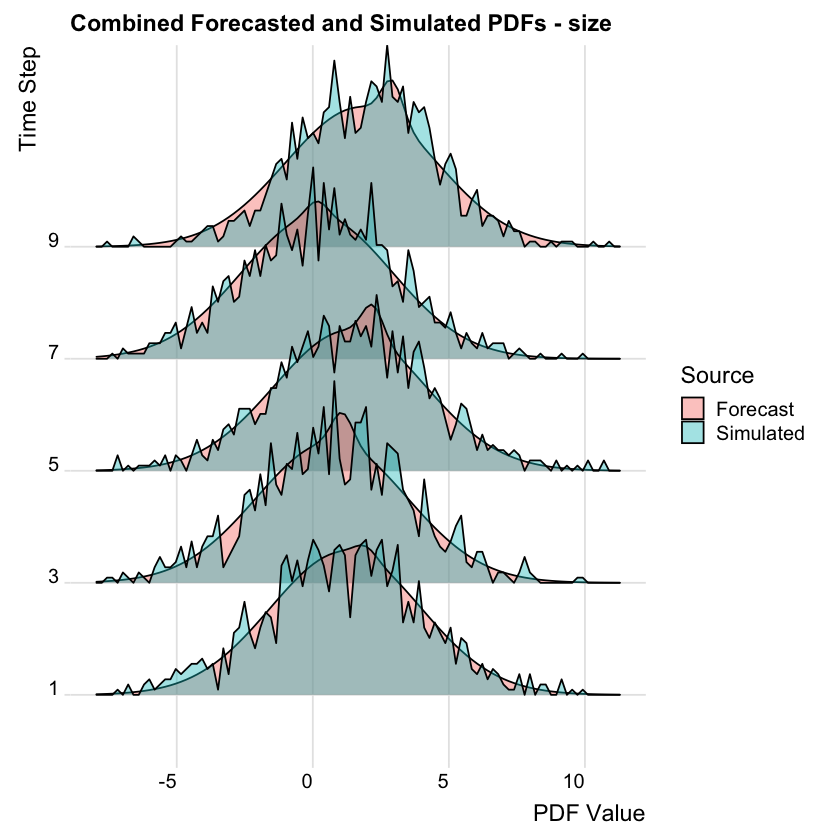

In [10]:
# Define the number of steps and the dimension to plot
n_steps <- nrow(forecasts)
plot_steps <- seq(1, n_steps, by = 2)  # Plot every second step for clarity

for (dimension in emission_vars) {
  # Get forecasted PDFs and simulated PDFs
  x_vals <- fc$x_vals[[dimension]]
  forecast_pdfs <- fc$forecasted_pdfs[[dimension]]
  simulated_pdfs_dim <- simulated_pdfs[[dimension]]

  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(x_vals, times = length(plot_steps) * 2),
    y = c(
      as.vector(forecast_pdfs[, plot_steps]),
      as.vector(simulated_pdfs_dim[, plot_steps])
    ),
    time = factor(rep(plot_steps, each = length(x_vals))),
    source = rep(c("Forecast", "Simulated"), each = length(x_vals) * length(plot_steps))
  )

  # Create the ridge plot
  print(
    ggplot(ridge_data, aes(x = x, y = time, height = y, group = interaction(time, source), fill = source)) +
      geom_density_ridges(stat = "identity", position = "identity", alpha = 0.4) +
      labs(
        x = "PDF Value",
        y = "Time Step",
        title = paste("Combined Forecasted and Simulated PDFs -", dimension),
        fill = "Source"
      ) +
      theme_ridges() +
      theme(axis.text.x = element_text(angle = 0, hjust = 1))
  )
}

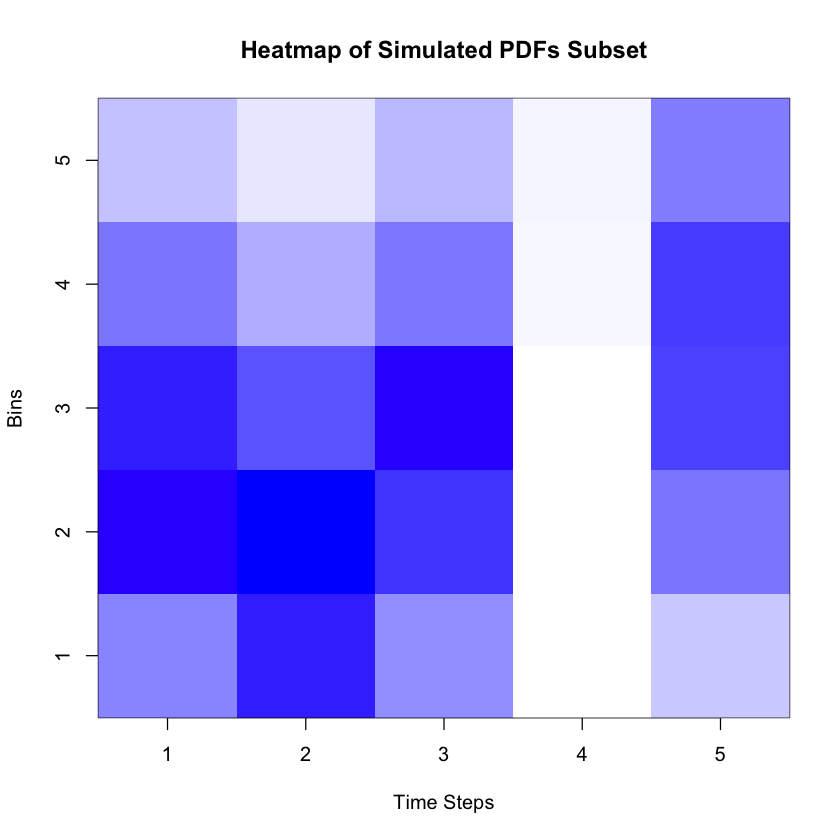

In [12]:
# Plot the subset of simulated_pdfs[[1]][1:5, 1:5]
subset_data <- simulated_pdfs[[1]][1:5, 1:5]

# Create a heatmap with a blue color scheme
image(
  1:ncol(subset_data), 1:nrow(subset_data), t(subset_data),
  xlab = "Time Steps", ylab = "Bins",
  main = "Heatmap of Simulated PDFs Subset",
  col = colorRampPalette(c("white", "blue"))(100)
)